# Лабораторная работа 1. Нейронные сети.

Результатом лабораторной работы является отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

# Часть 1. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [0]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape, y_train.shape)

Using TensorFlow backend.


(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

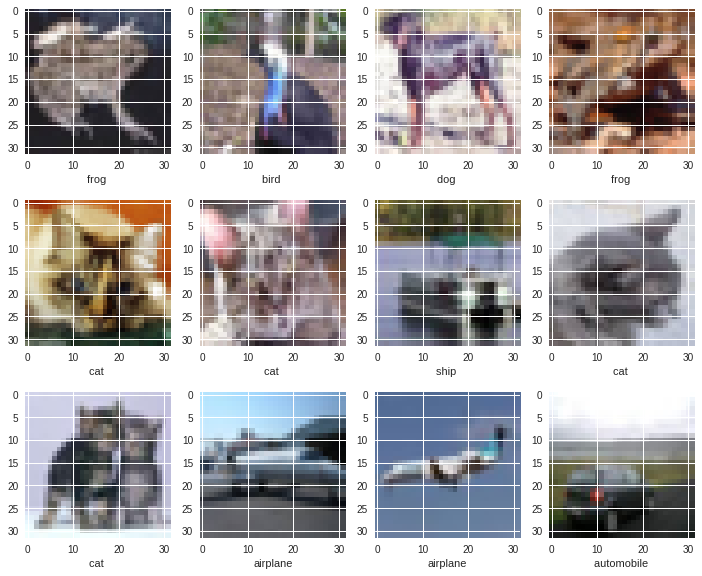

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [0]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

Исполните код ниже для проверки, что все выполнено корректно.

In [0]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [0]:
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score
from google.colab import files, drive

In [0]:
import keras
import keras.models as M
import keras.layers as L

from keras.optimizers import SGD
from keras.losses import sparse_categorical_crossentropy
from keras.metrics import sparse_categorical_accuracy

Создайте полносвязную сеть:

In [0]:
model = M.Sequential()
model.add(L.Flatten())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='relu'))
model.add(L.Softmax())

In [0]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (1 балл)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [0]:
model.compile('sgd', loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=[X_val, y_val])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 8s 192us/step - loss: 1.9307 - sparse_categorical_accuracy: 0.3100 - val_loss: 1.8242 - val_sparse_categorical_accuracy: 0.3365
Epoch 2/10
40000/40000 [==============================] - 8s 190us/step - loss: 1.7562 - sparse_categorical_accuracy: 0.3785 - val_loss: 1.7389 - val_sparse_categorical_accuracy: 0.3798
Epoch 3/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.6832 - sparse_categorical_accuracy: 0.4104 - val_loss: 1.6890 - val_sparse_categorical_accuracy: 0.4021
Epoch 4/10
40000/40000 [==============================] - 8s 197us/step - loss: 1.6340 - sparse_categorical_accuracy: 0.4272 - val_loss: 1.6391 - val_sparse_categorical_accuracy: 0.4199
Epoch 5/10
40000/40000 [==============================] - 8s 204us/step - loss: 1.5957 - sparse_categorical_accuracy: 0.4402 - val_loss: 1.5957 - val_sparse_categorical_accuracy: 0.4410
Epoch 6/10
40000/400

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.458
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (1 балл)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [0]:
model = M.Sequential()
model.add(L.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Flatten())
model.add(L.Dense(100, activation='relu'))
model.add(L.Softmax())

In [0]:
model.compile('sgd', loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=[X_val, y_val])

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 234us/step - loss: 2.5504 - sparse_categorical_accuracy: 0.2575 - val_loss: 2.3592 - val_sparse_categorical_accuracy: 0.3224
Epoch 2/10
40000/40000 [==============================] - 8s 188us/step - loss: 2.2711 - sparse_categorical_accuracy: 0.3546 - val_loss: 2.2070 - val_sparse_categorical_accuracy: 0.3683
Epoch 3/10
40000/40000 [==============================] - 8s 189us/step - loss: 1.8468 - sparse_categorical_accuracy: 0.4140 - val_loss: 1.5577 - val_sparse_categorical_accuracy: 0.4536
Epoch 4/10
40000/40000 [==============================] - 8s 190us/step - loss: 1.5044 - sparse_categorical_accuracy: 0.4745 - val_loss: 1.4751 - val_sparse_categorical_accuracy: 0.4834
Epoch 5/10
40000/40000 [==============================] - 8s 191us/step - loss: 1.4155 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.4062 - val_sparse_categorical_accuracy: 0.5008
Epoch 6/10
40000/400

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5387
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

In [0]:
def get_model(bn_after_conv=False, bn_after_dense=False):
    model = M.Sequential()
    
    model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
    if bn_after_conv:
        model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(L.Flatten())
    model.add(L.Dense(100))
    if bn_after_dense:
        model.add(L.BatchNormalization())
    model.add(L.Activation('relu'))
    model.add(L.Softmax())
    
    return model

def fit_model(model, optimizer, epochs=10, batch_size=32, verbose=1, callbacks=None):
    model.compile(optimizer, loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])
    return model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=[X_val, y_val], callbacks=callbacks)

**Задание 1.3 (0.5 балла)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

In [0]:
methods = {
    'sgd': 'sgd',
    'momentum': tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.9),
    'adam': 'adam'
}

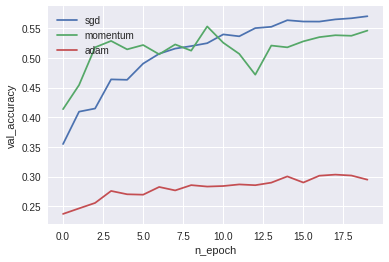

In [0]:
n_epoch = 20
x = np.arange(n_epoch)
legend = []
for key, value in methods.items():
    legend.append(key)
    hist = fit_model(get_model(), value, epochs=n_epoch, verbose=0)
    plt.plot(x, hist.history['val_sparse_categorical_accuracy'])

plt.legend(legend, loc='upper left')
plt.xlabel('n_epoch')
plt.ylabel('val_accuracy')

plt.show()

Лучше в данном случае работает SGD

**Задание 1.4 (0.5 балла)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

In [0]:
fit_model(get_model(bn_after_conv=True), 'sgd')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 11s 266us/step - loss: 1.6730 - sparse_categorical_accuracy: 0.4213 - val_loss: 1.5777 - val_sparse_categorical_accuracy: 0.4516
Epoch 2/10
40000/40000 [==============================] - 9s 234us/step - loss: 1.3323 - sparse_categorical_accuracy: 0.5329 - val_loss: 1.3779 - val_sparse_categorical_accuracy: 0.5153
Epoch 3/10
40000/40000 [==============================] - 9s 235us/step - loss: 1.2276 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.8344 - val_sparse_categorical_accuracy: 0.4265
Epoch 4/10
40000/40000 [==============================] - 9s 237us/step - loss: 1.1613 - sparse_categorical_accuracy: 0.5948 - val_loss: 1.3059 - val_sparse_categorical_accuracy: 0.5460
Epoch 5/10
40000/40000 [==============================] - 10s 238us/step - loss: 1.1226 - sparse_categorical_accuracy: 0.6070 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.5513
Epoch 6/10
40000/4

Добавление BatchNorm'а после сверточного слоя улучшило accuracy до 0.5949

In [0]:
fit_model(get_model(bn_after_dense=True), 'sgd')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 303us/step - loss: 3.3130 - sparse_categorical_accuracy: 0.3234 - val_loss: 2.8917 - val_sparse_categorical_accuracy: 0.2914
Epoch 2/10
40000/40000 [==============================] - 12s 298us/step - loss: 2.1171 - sparse_categorical_accuracy: 0.4917 - val_loss: 1.9760 - val_sparse_categorical_accuracy: 0.5042
Epoch 3/10
40000/40000 [==============================] - 13s 325us/step - loss: 1.7026 - sparse_categorical_accuracy: 0.5404 - val_loss: 1.6283 - val_sparse_categorical_accuracy: 0.5415
Epoch 4/10
40000/40000 [==============================] - 12s 308us/step - loss: 1.5203 - sparse_categorical_accuracy: 0.5629 - val_loss: 2.2334 - val_sparse_categorical_accuracy: 0.3951
Epoch 5/10
40000/40000 [==============================] - 12s 302us/step - loss: 1.4128 - sparse_categorical_accuracy: 0.5806 - val_loss: 1.9881 - val_sparse_categorical_accuracy: 0.4581
Epoch 6/10
4000

При добавлении BatchNorm'а после полносвязного слоя (без добавления после свертки) точность также улучшилась до 0.5856

In [0]:
fit_model(get_model(bn_after_conv=True, bn_after_dense=True), 'sgd')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 14s 345us/step - loss: 3.1867 - sparse_categorical_accuracy: 0.3478 - val_loss: 2.3649 - val_sparse_categorical_accuracy: 0.4813
Epoch 2/10
40000/40000 [==============================] - 12s 309us/step - loss: 1.9863 - sparse_categorical_accuracy: 0.5241 - val_loss: 1.7950 - val_sparse_categorical_accuracy: 0.5225
Epoch 3/10
40000/40000 [==============================] - 12s 302us/step - loss: 1.6351 - sparse_categorical_accuracy: 0.5514 - val_loss: 1.8126 - val_sparse_categorical_accuracy: 0.5009
Epoch 4/10
40000/40000 [==============================] - 12s 305us/step - loss: 1.4744 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.4929
Epoch 5/10
40000/40000 [==============================] - 12s 310us/step - loss: 1.3747 - sparse_categorical_accuracy: 0.5855 - val_loss: 1.3846 - val_sparse_categorical_accuracy: 0.5850
Epoch 6/10
4000

Добавление BatchNorm'а одновременно после свертки и после полносвязного слоя не дало дальнейшего улучшения accuracy

**Задание 1.5 (0.5 балла)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%.

In [0]:
class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self):
        super(keras.callbacks.Callback, self).__init__()

    def on_epoch_end(self, epoch, logs):
        if logs['val_sparse_categorical_accuracy'] >= 0.55:
            self.model.stop_training = True

batch_size=16, val_accuracy>=0.55 after 8 epochs which took 108.9690 seconds
batch_size=32, val_accuracy>=0.55 after 14 epochs which took 105.2045 seconds
batch_size=50, val_accuracy>=0.55 after 27 epochs which took 139.7143 seconds
batch_size=64, val_accuracy>=0.55 after 21 epochs which took 92.2159 seconds
batch_size=80, val_accuracy>=0.55 after 26 epochs which took 99.9629 seconds
batch_size=128, val_accuracy>=0.55 after 47 epochs which took 132.6810 seconds
batch_size=256, val_accuracy>=0.55 after 75 epochs which took 159.1738 seconds


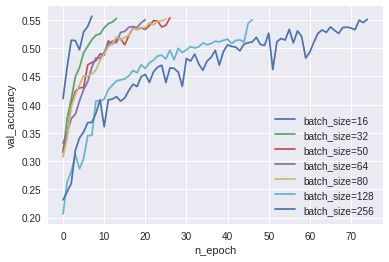

In [0]:
n_epoch = 100
x = np.arange(n_epoch)
legend = []
for batch_size in [16, 32, 50, 64, 80, 128, 256]:
    legend.append(f'batch_size={batch_size}')
    start = time.time()
    hist = fit_model(get_model(), 'sgd', epochs=n_epoch, batch_size=batch_size, verbose=0, callbacks=[EarlyStoppingByLossVal()])
    elapsed = time.time() - start
    
    num_epoch = len(hist.history['val_sparse_categorical_accuracy'])
    val_acc = hist.history['val_sparse_categorical_accuracy'] + [None]*(n_epoch - num_epoch)

    print(f'batch_size={batch_size}, val_accuracy>=0.55 after {num_epoch} epochs which took {elapsed:.4f} seconds')
    plt.plot(x, val_acc)

plt.legend(legend, loc='lower right')
plt.xlabel('n_epoch')
plt.ylabel('val_accuracy')

plt.show()

Быстрее всего модель достигает точности 55% с `batch_size=64`

**Задание 1.6 (0.5 балла)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [0]:
# A WHOLE LOT OF YOUR CODE

Напишите ваши выводы по проделанным экспериментам: что заработало, что — не очень. Постройте графики кривых обучения разных архитектур.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (5 баллов)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Добавил один сверточный слой с макс пулингом и батчнормом - качество улучшилось с 0.5950 до 0.6205

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))


model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))
model.add(L.Softmax())

In [0]:
fit_model(model, 'sgd')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 18s 449us/step - loss: 3.2057 - sparse_categorical_accuracy: 0.3326 - val_loss: 2.2610 - val_sparse_categorical_accuracy: 0.4978
Epoch 2/10
40000/40000 [==============================] - 15s 385us/step - loss: 1.9754 - sparse_categorical_accuracy: 0.5194 - val_loss: 1.7370 - val_sparse_categorical_accuracy: 0.5333
Epoch 3/10
40000/40000 [==============================] - 15s 386us/step - loss: 1.6003 - sparse_categorical_accuracy: 0.5603 - val_loss: 1.6356 - val_sparse_categorical_accuracy: 0.5226
Epoch 4/10
40000/40000 [==============================] - 16s 390us/step - loss: 1.4245 - sparse_categorical_accuracy: 0.5849 - val_loss: 1.6962 - val_sparse_categorical_accuracy: 0.5225
Epoch 5/10
40000/40000 [==============================] - 16s 393us/step - loss: 1.3269 - sparse_categorical_accuracy: 0.5997 - val_loss: 1.4710 - val_sparse_categorical_accuracy: 0.5624
Epoch 6/10
4000

Добавил в начало сети дополнительный сверточный слой без макспулинга с батчнормом, качество улучшилось до 0.7019

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())

model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Softmax())

In [0]:
fit_model(model, 'sgd')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 23s 575us/step - loss: 3.0480 - sparse_categorical_accuracy: 0.3785 - val_loss: 2.2771 - val_sparse_categorical_accuracy: 0.4832
Epoch 2/10
40000/40000 [==============================] - 20s 491us/step - loss: 1.7965 - sparse_categorical_accuracy: 0.5690 - val_loss: 2.0655 - val_sparse_categorical_accuracy: 0.4701
Epoch 3/10
40000/40000 [==============================] - 20s 490us/step - loss: 1.4048 - sparse_categorical_accuracy: 0.6190 - val_loss: 1.4101 - val_sparse_categorical_accuracy: 0.6087
Epoch 4/10
40000/40000 [==============================] - 20s 489us/step - loss: 1.2255 - sparse_categorical_accuracy: 0.6455 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.6585
Epoch 5/10
40000/40000 [==============================] - 20s 491us/step - loss: 1.1084 - sparse_categorical_accuracy: 0.6698 - val_loss: 1.1861 - val_sparse_categorical_accuracy: 0.6518
Epoch 6/10
4000

Добавил еще один слой без макс пулинга, начал обучаться 20 эпох, потому что за 10 не получал прироста качества, но качество все еще не улучшилось

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=80, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())

model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Softmax())

In [0]:
fit_model(model, 'sgd', epochs=20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 29s 713us/step - loss: 2.9619 - sparse_categorical_accuracy: 0.3970 - val_loss: 2.1949 - val_sparse_categorical_accuracy: 0.5163
Epoch 2/20
40000/40000 [==============================] - 24s 593us/step - loss: 1.7044 - sparse_categorical_accuracy: 0.5887 - val_loss: 1.5981 - val_sparse_categorical_accuracy: 0.5977
Epoch 3/20
40000/40000 [==============================] - 24s 595us/step - loss: 1.3175 - sparse_categorical_accuracy: 0.6403 - val_loss: 1.4493 - val_sparse_categorical_accuracy: 0.6093
Epoch 4/20
40000/40000 [==============================] - 23s 587us/step - loss: 1.1176 - sparse_categorical_accuracy: 0.6797 - val_loss: 1.2809 - val_sparse_categorical_accuracy: 0.6342
Epoch 5/20
40000/40000 [==============================] - 23s 587us/step - loss: 1.0005 - sparse_categorical_accuracy: 0.7001 - val_loss: 1.1298 - val_sparse_categorical_accuracy: 0.6670
Epoch 6/20
4000

Добавил полносвязный слой после Flatten'а, достиг качества 0.7045

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=80, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())

model.add(L.Dense(256))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Softmax())

In [0]:
fit_model(model, 'sgd', epochs=20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 32s 812us/step - loss: 2.9978 - sparse_categorical_accuracy: 0.3968 - val_loss: 2.3503 - val_sparse_categorical_accuracy: 0.4462
Epoch 2/20
40000/40000 [==============================] - 27s 684us/step - loss: 1.7606 - sparse_categorical_accuracy: 0.5731 - val_loss: 1.5216 - val_sparse_categorical_accuracy: 0.5884
Epoch 3/20
40000/40000 [==============================] - 27s 685us/step - loss: 1.3470 - sparse_categorical_accuracy: 0.6305 - val_loss: 1.3552 - val_sparse_categorical_accuracy: 0.6210
Epoch 4/20
40000/40000 [==============================] - 28s 690us/step - loss: 1.1297 - sparse_categorical_accuracy: 0.6716 - val_loss: 1.2316 - val_sparse_categorical_accuracy: 0.6493
Epoch 5/20
40000/40000 [==============================] - 28s 689us/step - loss: 0.9834 - sparse_categorical_accuracy: 0.7025 - val_loss: 1.1697 - val_sparse_categorical_accuracy: 0.6432
Epoch 6/20
4000

Добавил макспулинг после 3й свертки, качество улучшилось до 0.7143

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=80, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Activation('relu'))

model.add(L.Flatten())

model.add(L.Dense(256))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Softmax())

In [0]:
fit_model(model, 'sgd', epochs=20)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 23s 580us/step - loss: 3.0621 - sparse_categorical_accuracy: 0.3667 - val_loss: 2.2950 - val_sparse_categorical_accuracy: 0.4640
Epoch 2/20
40000/40000 [==============================] - 21s 513us/step - loss: 1.7755 - sparse_categorical_accuracy: 0.5648 - val_loss: 1.5617 - val_sparse_categorical_accuracy: 0.5922
Epoch 3/20
40000/40000 [==============================] - 21s 514us/step - loss: 1.3694 - sparse_categorical_accuracy: 0.6214 - val_loss: 1.3205 - val_sparse_categorical_accuracy: 0.6179
Epoch 4/20
40000/40000 [==============================] - 21s 515us/step - loss: 1.1514 - sparse_categorical_accuracy: 0.6641 - val_loss: 1.1899 - val_sparse_categorical_accuracy: 0.6470
Epoch 5/20
40000/40000 [==============================] - 21s 515us/step - loss: 1.0337 - sparse_categorical_accuracy: 0.6854 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6063
Epoch 6/20
4000

Время для аугментации данных, сеть с предыдущего шага осталась без изменений

In [0]:
model = M.Sequential()

model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=20, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Conv2D(filters=80, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())

model.add(L.Dense(256))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.Activation('relu'))

model.add(L.Softmax())

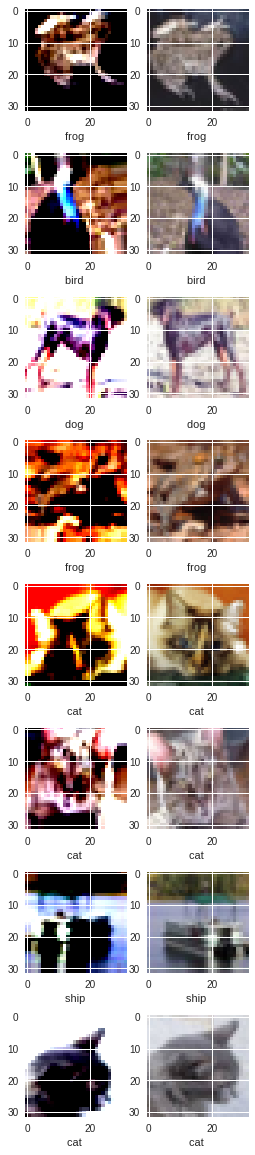

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import itertools

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(X_train)

batch = list(itertools.islice(datagen.flow(X_train, y_train, batch_size=8, shuffle=False), 1))[0]

plt.figure(figsize=[4,26])
for i, (X_train_, y_train_) in enumerate(zip(*batch)):
    plt.subplot(10, 2, 2*i + 1)
    plt.xlabel(class_names[y_train_[0]])
    plt.imshow(np.clip(X_train_, 0, 1))
    
    plt.subplot(10, 2, 2*(i + 1))
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])    

In [0]:
test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(X_train)

def transform_test(X, y):
    return list(itertools.islice(test_datagen.flow(X, y, batch_size=len(X), shuffle=False), 1))[0][0]

X_val_batch = transform_test(X_val, y_val)

def train(name, model, optim='sgd', n_epoch=20, batch_size=32):
    model.compile(optim, loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])
    best_acc = 0
    for e in range(n_epoch):
        t = time.time()
        batches = 0
        for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
            model.fit(X_batch, y_batch, verbose=0)
            batches += 1
            if batches >= len(X_train)/batch_size:
                break
        
        acc_new = accuracy_score(y_val, model.predict_classes(X_val_batch))
        if acc_new >= best_acc:
            best_acc = acc_new
            model.save_weights(name, overwrite=True)
        
        print(f'Epoch #{e + 1}/{20}, accuracy: {acc_new:.4f}, elapsed: {time.time() - t:.2f} s')
    print(f'Best accuracy: {best_acc:.4f}')

In [0]:
train('sgd_trained', model)

Epoch #1/20, accuracy: 0.5230, elapsed: 45.36 s
Epoch #2/20, accuracy: 0.5791, elapsed: 41.01 s
Epoch #3/20, accuracy: 0.5724, elapsed: 40.69 s
Epoch #4/20, accuracy: 0.6307, elapsed: 40.90 s
Epoch #5/20, accuracy: 0.6324, elapsed: 40.63 s
Epoch #6/20, accuracy: 0.6889, elapsed: 40.95 s
Epoch #7/20, accuracy: 0.6742, elapsed: 40.60 s
Epoch #8/20, accuracy: 0.6786, elapsed: 40.57 s
Epoch #9/20, accuracy: 0.6881, elapsed: 40.51 s
Epoch #10/20, accuracy: 0.7258, elapsed: 40.43 s
Epoch #11/20, accuracy: 0.6824, elapsed: 40.43 s
Epoch #12/20, accuracy: 0.7170, elapsed: 40.60 s
Epoch #13/20, accuracy: 0.7405, elapsed: 40.22 s
Epoch #14/20, accuracy: 0.7336, elapsed: 40.74 s
Epoch #15/20, accuracy: 0.7530, elapsed: 40.44 s
Epoch #16/20, accuracy: 0.7603, elapsed: 40.59 s
Epoch #17/20, accuracy: 0.7358, elapsed: 40.65 s
Epoch #18/20, accuracy: 0.7466, elapsed: 40.79 s
Epoch #19/20, accuracy: 0.7270, elapsed: 41.32 s


Здесь обучение запускалось 2 раза (из-за этого на первой эпохе уже такое качество), также попробовал Adam optimizer - качество получил лучше, чем с SGD. 

Не дождался отработки 20 эпох, так как был близок к OOM :)

In [0]:
train('second', model, 'adam')

Epoch #1/20, accuracy: 0.7475, elapsed: 48.45 s
Epoch #2/20, accuracy: 0.7747, elapsed: 45.01 s
Epoch #3/20, accuracy: 0.7972, elapsed: 45.10 s
Epoch #4/20, accuracy: 0.8012, elapsed: 44.91 s
Epoch #5/20, accuracy: 0.7636, elapsed: 44.77 s
Epoch #6/20, accuracy: 0.7781, elapsed: 44.82 s
Epoch #7/20, accuracy: 0.7850, elapsed: 44.65 s
Epoch #8/20, accuracy: 0.7972, elapsed: 44.65 s
Epoch #9/20, accuracy: 0.8011, elapsed: 44.86 s
Epoch #10/20, accuracy: 0.7773, elapsed: 45.05 s
Epoch #11/20, accuracy: 0.7847, elapsed: 45.07 s
Epoch #12/20, accuracy: 0.8154, elapsed: 45.24 s
Epoch #13/20, accuracy: 0.8004, elapsed: 45.14 s
Epoch #14/20, accuracy: 0.8025, elapsed: 45.16 s
Epoch #15/20, accuracy: 0.8128, elapsed: 45.25 s


KeyboardInterrupt: ignored

In [0]:
model.load_weights('second')

Момент истины: проверьте, какого качества достигла ваша сеть.

In [0]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(transform_test(X_test, y_test)))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8198
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Видно, что добавление новых слоев помогает, однако после добавления какого-то количества слоев дальнейшее добавление слоев не приводит к повышению качества, видимо, из-за того, что весов становится слишком много и данных не хватает чтобы нормально обучить их все. В этот момент на помощь приходит аугментация данных, с помощью которой можно каждую эпоху генерить новые данные из тестовой выборки. Аугментация данных дала значительный прирост качества.

# Часть 2. Fine-tuning обученных нейросетей

В этой части задания вам предстоит поработать с настоящими монстрами: сетями с почти сотней слоёв и десятками миллионов параметров. Например, такими:

![img](https://alexisbcook.github.io/assets/inception.png)
<center>googlenet inception v3</center>

Если внимательно всмотреться в картинку, можно заметить, что синим цветом обозначены свёрточные слои, красным — pooling, зелёным — конкатенация входов и т.п.

__Чем кормить такого монстра?__

Огромные нейросети обучаются на огромных массивах данных. В компьютерном зрении таких несколько, но самый популярный из них [ImageNet](http://image-net.org/). В этой выборке более миллиона изображений.

Задача этой сети состоит в классификации каждого изображения в один из 1000 классов. Вот они:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

classes = pickle.load(open('classes.pkl','rb'))
print(classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


## Зоопарк нейросетей в keras

Если вы дошли до этого задания, значит вы уже знакомы с библиотекой Керас. Так вот, в ней кроме всего прочего, есть зоопарк предобученных нейросетей: [__`keras.applications`__](https://keras.io/applications/).

Ниже пример кода, который загружает обученную модель с картинки выше ([здесь](https://keras.io/applications/#inceptionv3) можно узнать о ней подробнее).

**Внимание!**
InceptionV3 требует много памяти для работы. Если ваш ПК начинает зависать:
* закройте всё кроме jupyter и браузера с одной вкладкой;
* если не помогло, загрузите эту тетрадку в [google colab](https://colab.research.google.com/) и работайте там;
* замените `zoo.InceptionV3` на `zoo.MobileNet`. Однако в этом случае вам придётся исправить и предобработку картинок.

Выберете оптимальный для вас вариант и начнем работу!

In [0]:
import keras, keras.layers as L
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Функция ниже позволяет найти для заданного изображения топ10 классов по мнению InceptionV3.

In [0]:
from skimage.transform import resize
def predict_top10(img):
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    plt.imshow(img)
    plt.show()

    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    probs = model.predict(img_preprocessed)[0]
    labels = probs.argsort()[-1:-10:-1]

    print('top-10 classes:')
    for l in labels:
        print('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

Проверим, как она работает на близкой к обучающей выборке картинке:

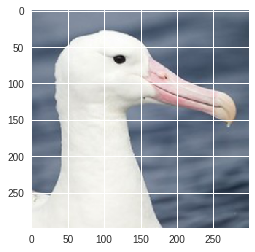

top-10 classes:
0.9282	albatross
0.0016	turnstile
0.0008	drake
0.0005	collie
0.0004	hammerhead
0.0004	Shetland sheepdog
0.0004	nipple
0.0004	cello
0.0004	goose


In [0]:
predict_top10(plt.imread('albatross.jpg'))

А теперь попробуем ее на чем-то неожиданном!

--2018-11-11 15:04:59--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.27.152.170, 104.27.153.170, 2606:4700:30::681b:98aa, ...
Connecting to cdn.com.do (cdn.com.do)|104.27.152.170|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2018-11-11 15:04:59--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.27.152.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0.03s   

2018-11-11 15:04:59 (1.71 MB/s) - ‘img.jpg’ saved [51048/51048]



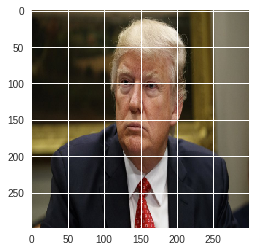

top-10 classes:
0.2418	suit
0.0915	groom
0.0294	Windsor tie
0.0111	wig
0.0095	oboe
0.0082	academic gown
0.0072	bow tie
0.0055	notebook
0.0050	mortarboard


In [0]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg
predict_top10(plt.imread('img.jpg'))

## Dogs Vs Cats

А теперь попробуем построить классификатор, который отличает изображение кошки от собаки. 

![img](https://dingo.care2.com/pictures/greenliving/1203/1202163.large.jpg)

Код ниже позволяет вам загрузить данные, необходимые для данного задания.

In [0]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2018-11-11 14:49:10--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/d61lupw909hc785/dogs_vs_cats.train.zip [following]
--2018-11-11 14:49:10--  https://www.dropbox.com/s/dl/d61lupw909hc785/dogs_vs_cats.train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48cb8a4c4e0f1d26b8f222332c.dl.dropboxusercontent.com/cd/0/get/AVWMHcC8ALML8or1BQo57IxO8Npl1WXnKheyhsnCc9qB0yAtY6kIHpgE3FmFw3AEavb_eLNt1LUbpP-rmPpkhOXqIWsnUPQBxMzfp-Bl2jDgRiKGecZw0WZkn7tw25Z_QymWNNJ6mBZGetIgzY8ZpM4bNU9R3XC7fmA44yX6jdmOJUSvFDiT0qcMphDfM6YfA-U/file?dl=1 [following]
--2018-11-11 14:49:10--  https://uc48cb8a4c4e0f1d26b8f222332c.dl.dropboxusercontent.com/cd/0/get/AVWMHcC8ALML8or1BQo

## Sklearn way

**Задание 2.1 (1 балл)** В вашем распоряжении есть предобученная сеть InceptionV3. Ваша задача — обучить классификатор из sklearn (на ваш выбор), который будет отличать котов от собак, используя __активации нейронной сети в качестве признаков__.

Для начала, прочитайте данные и сформируйте для вашего классификатора обучающую и тестовую выборки в пропорции 4:1. 

В вашем распоряжении всего 25 000 изображений различного размера, все в формате JPEG. Все картинки лежат в папке __`./train`__. Изображения кошек имеют название вида `./train/cat.*.jpg`, собак — `./train/dog.*.jpg`.

Считайте данные и для каждой картинки вычислите признаки из промежуточного слоя свёрточной сети. В качестве признаков можно выбрать какой-нибудь слой или несколько слоёв сети. Попробуйте найти комбинацию слоёв, которая работает лучше всего.

[Здесь](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer) можно почитать как посчитать активацию промежуточных слоёв.

In [0]:
import os

images_dir = 'train'
files = os.listdir(images_dir)
X_path = list(map(lambda x: os.path.join(images_dir, x), files))
y = list(map(lambda x: 1 if x.startswith('cat') else 0, files))

Разделите данные на обучение и тест в отношении 4:1.

In [0]:
X_path_train, X_path_test, y_train, y_test = train_test_split(X_path, y, test_size=0.2, random_state=42)
X_path_train[0], len(X_path_train)

('train/cat.4554.jpg', 20000)

Обучите поверх этих признаков классификатор из sklearn (можно попробовать несколько и выбрать лучший). Попробуйте получить ROC-AUC __хотя бы 99%__.

In [0]:
def preprocess(image_path):
    img = plt.imread(image_path)
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    return img_preprocessed

def get_batches(X_path, batch_size=1000):
    for i in range(len(X_path)//batch_size):
        t = time.time()
        arr = np.concatenate(list(map(preprocess, X_path[i*batch_size:(i + 1)*batch_size])))
        print(f'Processing batch #{i} took {time.time() - t:.2f} s')
        yield arr

In [0]:
def get_output(model, img_path):
    img = plt.imread(img_path)
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    return model.predict(img_preprocessed)

In [0]:
from keras.models import Model

layer_name = 'avg_pool'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
get_output(intermediate_layer_model, X_path_train[0]).shape

(1, 2048)

In [0]:
import gc

features = []
for X_batch in get_batches(X_path_train):
    features.append(model.predict(X_batch))
    gc.collect()

X_train_features = np.concatenate(features)
X_train_features.shape

Processing batch #0 took 34.86 s
Processing batch #1 took 28.22 s
Processing batch #2 took 34.66 s
Processing batch #3 took 28.52 s
Processing batch #4 took 34.22 s
Processing batch #5 took 28.87 s
Processing batch #6 took 34.21 s
Processing batch #7 took 28.38 s
Processing batch #8 took 35.47 s
Processing batch #9 took 28.39 s
Processing batch #10 took 32.85 s
Processing batch #11 took 28.23 s
Processing batch #12 took 32.31 s
Processing batch #13 took 27.78 s
Processing batch #14 took 31.12 s
Processing batch #15 took 28.77 s
Processing batch #16 took 30.88 s
Processing batch #17 took 28.09 s
Processing batch #18 took 30.04 s
Processing batch #19 took 27.76 s


(20000, 1000)

In [0]:
import gc

features = []
for X_batch in get_batches(X_path_test):
    features.append(model.predict(X_batch))
    gc.collect()
    
X_test_features = np.concatenate(features)
X_test_features.shape

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf.fit(X_train_features, y_train)
y_pred = clf.predict_proba(X_test_features)

In [0]:
y_test_classes = np.array(y_test)
y_test_classes = np.concatenate([[(y_test_classes == 0).astype(int)], [(y_test_classes == 1).astype(int)]]).T
y_test_classes[:2]

array([[1, 0],
       [0, 1]])

Опишите ваши выводы о проделанной работе.

In [0]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test_classes, y_pred)

0.9992882267828698

Самое сложное в этом задании - заставить colab не свалиться с OOM. Так как все картинки в память не влезают, пришлось бить их на батчи и по очереди скармливать сети, получая фичи для классификатора. Я взял слой после AveragePooling'а, который выдает 2048 признаков (слои, находящиеся ближе к началу не стал брать, так как в них слишком много параметров - справиться с колабом, который постоянно сдыхает стало бы еще сложнее). В качестве классификатора использовал RandomForest с 100 деревьями

## Fine-tuning

**Задание 2.2 (2 балла)** Давайте попробуем добиться ещё большего качества через дообучение (fine-tuning) модели. Новая цель — получить качество лучше, чем у классификатора из предыдущего пункта на признаках `InceptionV3`. Цель этого задания: получить значение ROC-AUC __не меньше 99.5%__.

__Шаг 1.__  Постройте сеть, в которой InceptionV3 "без головы" используется в качестве первого слоя. Поверх неё надстройте новую голову из `keras.layers` — она будет отличать котов от собак. Это можно сделать с помощью [общего интерфейса модели](https://keras.io/models/model/).

In [0]:
layer_name = 'avg_pool'

for layer in model.layers:
    layer.trainable = False

model_out = model.get_layer(layer_name).output
out = L.Dense(2, activation='softmax')(model_out)
model2 = Model(inputs=model.input, outputs=out)

get_output(model2, X_path_train[0])

array([[0.08599032, 0.9140097 ]], dtype=float32)

__Шаг 2.__ Обучите "голову" на обучающей выборке, не меняя весов изначальной сети. Частично обучать сеть в keras можно [вот так](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers).

In [0]:
def get_batches(X_path, y_train, batch_size):
    n = len(X_path)//batch_size
    for i in range(n):
        t = time.time()
        arr = np.concatenate(list(map(preprocess, X_path[i*batch_size:(i + 1)*batch_size])))
        print(f'\rProcessing batch #{i + 1}/{n} took {time.time() - t:.2f} s', end='')
        yield arr, y_train[i*batch_size:(i + 1)*batch_size]

def roc_auc_batch(model, X_path, y_test, batch_size):
    pred = []
    n = len(X_path)//batch_size
    for i in range(n):
        print(f'\rProcessing accuracy #{i + 1}/{n}', end='')
        pred.append(model.predict(np.concatenate(list(map(preprocess, X_path[i*batch_size:(i + 1)*batch_size])))))
    pred = np.concatenate(pred)
    return roc_auc_score(y_test, pred)
        
def train(name, model, optim='sgd', n_epoch=20, batch_size=100):
    model.compile(optim, loss=sparse_categorical_crossentropy, metrics=[sparse_categorical_accuracy])
    best_acc = 0
    for e in range(n_epoch):
        t = time.time()
        for X_batch, y_batch in get_batches(X_path_train, y_train, batch_size):
            model.fit(X_batch, y_batch, verbose=0)
        
        print()
        acc_new = roc_auc_batch(model, X_path_test, y_test_classes, batch_size=1000)
        if acc_new >= best_acc:
            best_acc = acc_new
            model.save_weights(name, overwrite=True)
        
        print(f'\rEpoch #{e + 1}/{n_epoch}, accuracy: {acc_new:.6f}, elapsed: {time.time() - t:.2f} s')
    print(f'Best accuracy: {best_acc:.4f}')

In [0]:
train('model2', model2, 'adam', n_epoch=2)

Processing batch #200/200 took 2.23 s
Epoch #1/20, accuracy: 0.999286, elapsed: 881.19 s
Processing batch #200/200 took 2.02 s
Epoch #2/20, accuracy: 0.999406, elapsed: 836.79 s
Best accuracy: 0.9994


__Sanity check:__ После этого шага ваша модель должна уже быть сравнима по точности с моделями из задания 1.

Если всё получилось, самое время [сохранить модель](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model).

In [0]:
model.save_weights('model2', overwrite=True)

__Шаг 3.__ "Разморозьте" несколько предыдущих слоёв модели и продолжите обучение. На этом этапе важно не переобучиться: смотрите на качество на валидации.

Если качество не улучшается, а сразу идёт вниз, попробуйте уменьшить число обучаемых слоёв или воспользуйтесь [аугментацией данных](https://keras.io/preprocessing/image/). В общем случае, всегда полезно помнить про аугментацию данных даже если и без неё всё работает — иногда она творит [чудеса](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced).

In [0]:
layer_name = 'avg_pool'

for layer in model.layers:
    layer.trainable = False

last_layer = model.get_layer(layer_name)
last_layer.trainable = True

model_out = last_layer.output
out = L.Dense(2, activation='softmax')(model_out)
model3 = Model(inputs=model.input, outputs=out)

get_output(model3, X_path_train[0])

array([[0.7567769, 0.2432231]], dtype=float32)

__Шаг 4.__ Вычислите финальное качество.

In [0]:
train('model3', model3, 'adam', n_epoch=2)

Processing batch #200/200 took 1.94 s
Epoch #1/2, accuracy: 0.999183, elapsed: 805.99 s
Processing batch #200/200 took 2.03 s
Epoch #2/2, accuracy: 0.999425, elapsed: 802.11 s
Best accuracy: 0.9994

Напишите отчёт и вознаградите себя за старания чем-нибудь.

После обучения сети с обучением только замененной "головы" получил roc-auc=0.999406 (с RandomForest был 0.99928), то есть качество немного улучшилось.

После обучения замененной головы и предыдущего слоя из Inception'а, получил качество 0.999425, но кажется, что это незначительное улучшение

# Всё сделали, но азарт не прошел?

В таких случаях можно пробовать следующие техники:
* Ансамбль из нескольких предобученных нейросетей. Bagging? Stacking? Boosting? Всё что пожелаете.
* Более честный эксперимент: разделяем данные на train/__dev__/test, все сравнения делаем по dev, а test используем только в самом конце.
* Аугментировать данные картинками из интернета. Уж чего, а котиков и собачек там хватает.

# Часть 3. Рекуррентные языковые модели

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSj85jp-W-V-Bz8ZBjFJYIkV1TTxQxTMh4iqls_rRt8O-sraL08PA)

В этой части домашней работы мы создадим языковую модель на рекуррентных нейросетях (RNN) и заставим её придумывать имена.

__Языковая модель__, если вкратце, это модель, которая умеет как предсказывать вероятность некоторого текста. Ее можно использовать также чтобы генерировать текст в соответствии с обученными вероятностями. Задание будет заключаться в том, чтобы научить модель генерировать новые имена, скормив ей для этого 8к существующих.

В данном случае в качестве входных данных мы будет работать со строками, которые можно рассматривать как последовательности _символов_: $\{x_0, x_1, x_2, ..., x_n\}$. 

Наша основная задача — научиться предсказывать вероятность следующего символа:
$$ p(x_0, x_1, x_2, ..., x_n) = \prod_t p(x_t | x_0, ... x_{t - 1}) $$

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Данные

Мы будем строить языковую модель по ~8k человеческих имён на латинице. Если когда-нибудь вам нужно будет дать имя своему ребёнку, у вас будет для этого генеративная нейросетевая модель.

Давайте их прочитаем:
* Считайте все строки из файла `names` в список
* В начало каждой строки допишите __пробел__
* В конце сроки не должно быть переноса (`\n`)

In [0]:
import os
start_token = " "

with open('names', encoding='utf8') as f:
    lines = list(map(lambda x: start_token + x[:-1], f.readlines()))

In [0]:
assert all(line[0] == start_token for line in lines)
assert all(line[-1] != '\n' for line in lines)

In [4]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Проверьте, что все корректно:

In [5]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)
assert MAX_LENGTH == 16 , "max length (for names) should be 16. remove assert if you work on different dataset"

max length = 16


## Словари

В начале нам будет необходимо построить "словарь" — упорядоченное множество уникальных символов, которые сеть может породить. Это нужно, чтобы уметь сопоставить каждому символу свой номер. Перед отправкой в сеть все символы будут кодироваться их номерами в словаре.

Также необходимо добавить в словарь пробельный символ, который будет использоваться в качестве специального токена.

In [6]:
tokens = set(''.join(lines))

tokens = sorted(list(tokens))

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


А теперь построим обратный словарь: для каждой буквы посчитаем её номер в списке токенов.

In [0]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

И проверим, все ли корректно:

In [8]:
assert len(tokens) == len(token_to_id), "число токенов должно совпадать"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "словарь должен указывать на индекс буквы в tokens"

print("Кажется заработало...")

Кажется заработало...


Имея построенное соответствие, можно преобразовать батч входных данных в матрицу int32 номеров токенов. Так как в батче все строки должны быть одной длины, слишком короткие строки в батче нужно будет дополнить пробелами (паддинг).

In [0]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i]))
        lines_ix[i, :len(line_ix)] = line_ix

    return lines_ix

In [10]:
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 30 29 35 29 33 40  0]
 [ 0  9 40 43 46 53  0  0  0]
 [ 0 18 46 37 47 47 37 33  0]
 [ 0  9 37 43 50 29 42 42 33]]


## Один шаг RNN

Рекуррентная нейронная сеть (RNN) — это такая сеть с <s>блокнотом</s> состоянием $h$, в который она умеет писать то, что видела.

Сеть начинает с пустого $h_0 = \vec 0$, после чего текст обрабатывается по одному символу:
* $x_t$ — очередной символ, $h_t$ — предыдущее состояние
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — новое состояние
* $p(x_{t+1} | h_{t+1}) = \text{get_probs}(h_{t+1})$ — вероятность следующего символа



<img src="https://i.imgur.com/8l4qFF0.png" width=480>

Поскольку $x_t$ это индекс символа в словаре (=натуральное число), то ему можно сопоставить некоторый обучаемый вектор (*embedding*).

**Задание 3.1 (0.75 балла)**. Реализуйте вычисление нового состояния *get_h_next* и вероятности следующего символа *get_probs*, после чего напишите код для одного шага рекуррентной сети *rnn_one_step*, как на схеме выше.

In [11]:
import tensorflow as tf
import keras, keras.layers as L

emb_size, rnn_size = 16, 64

Using TensorFlow backend.


Создадим слой, который сопоставляет каждому из n_tokens входов свой обучаемый вектор:

In [0]:
embed_x = L.Embedding(n_tokens, emb_size)

Теперь инициализируем слой, вычисляющий следующее состояния $[emb(x_t), h_t] \to h_{t+1}$.

In [0]:
get_h_next = L.Dense(rnn_size, activation='tanh')

И, наконец, слой предсказывающий вероятности $h_{t+1} \to P(x_{t+1}|h_{t+1})$.

In [0]:
get_probs = L.Dense(n_tokens, activation='softmax')

Для реализации одного шага RNN реализуйте следующую последовательность действий:
1. замените номер символа на его вектор (embedding) (*hint*: возможно, вам потребуется tf.reshape);
2. сконкатенируйте вектор входа и предыдущее состояние;
3. вычислите следующее состояние сети;
4. предскажите вероятности для языковой модели P(x_next | h_next).

In [0]:
def rnn_one_step(x_t, h_t):    
    emb = embed_x(x_t)
    h_next = get_h_next(tf.concat([emb, h_t], axis=1))
    output_probs = get_probs(h_next)
    
    return h_next, output_probs

Проверим, что все работает:

In [0]:
input_sequence = tf.placeholder('int32', (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

# начальное состояние из нулей
h0 = tf.zeros([batch_size, rnn_size])

In [0]:
h1, p_y1 = rnn_one_step(input_sequence[:, 0], h0)

dummy_data = np.arange(MAX_LENGTH * 2).reshape([2, -1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_h1, test_p_y1 = sess.run([h1, p_y1],  {input_sequence: dummy_data})

assert test_h1.shape == (len(dummy_data), rnn_size)
assert test_p_y1.shape == (len(dummy_data), n_tokens) and np.allclose(test_p_y1.sum(-1), 1)

## Много шагов RNN

После того как был реализован один шаг нейросети, самое время сделать этих шагов побольше. Самый простой способ это сделать — написать цикл для фиксированного числа шагов (`MAX_LENGTH`).

**Задание 3.2 (0.25 балла)**. Реализуйте много шагов рекуррентной сети, на каждом шаге вычисляя следующее состояние RNN, исходя из предыдущего, при этом не забывая про *get_h_next* и *get_probs*.

In [0]:
h_prev = h0
predicted_probs = []

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    # YOUR CODE

    h_next, probs_next = rnn_one_step(x_t, h_prev)
    
    # END OF YOUR CODE
    predicted_probs.append(probs_next)
    h_prev = h_next
    
predicted_probs = tf.stack(predicted_probs, axis=1)

In [0]:
assert predicted_probs.shape.as_list() == [None, MAX_LENGTH, n_tokens]
assert h_prev.shape.as_list() == h0.shape.as_list()

## Обучение RNN

Как и любую вероятностную модель, RNN можно обучить методом максимизации log-правдоподобия по всей выборке $D$:

$$ \theta = \underset \theta {argmax} \log P(D) $$

где
$$ \log P(D) = \underset {\vec x \in D} \sum \log P(\vec x) = \underset {\vec x \in D} \sum \underset {x_t \in \vec x} \sum \log P(x_t | x_0, ..., x_{t+1})$$

C тем же успехом мы можем __минимизировать__ кроссэнтропию — то же самое, но с минусом.

In [20]:
predictions_matrix = predicted_probs[:, :-1]
answers_matrix = tf.one_hot(input_sequence[:, 1:], n_tokens)

print('predictions_matrix:', predictions_matrix.shape)
print('answers_matrix:', predictions_matrix.shape)

predictions_matrix: (?, 15, 55)
answers_matrix: (?, 15, 55)


**Задание 3.3 (0.5 балла)**. Реализуйте вычисление функции потерь (кроссэнтропия) и шаг градиентного спуска.

### Цикл обучения

**Задание 3.4 (0.5 балла)**. Напишите цикл обучения:
1. выбираем `batch_size` случайных строчек
2. преобразуем их в матрицу индексов
3. вычисляем функцию потерь и делаем шаг обучения
4. записываем функцию потерь в `history`

Для удобства отладки рекомендуем печатать или рисовать промежуточные результаты раз в несколько итераций.

Также постарайтесь обойтись одним `sess.run` на итерацию цикла.

In [0]:
batch_size = 32
history = []

sess.run(tf.global_variables_initializer())

In [0]:
from random import sample

for i in range(1000):
    batch = to_matrix(sample(lines, batch_size))
    loss_i, _ = sess.run([loss, optimize], {input_ix: batch})
    train_history.append(loss_i)

In [0]:
plt.plot(history)
plt.grid()

## Применение RNN

Только что у нас обучилась модель, которая предсказывает вероятности следующего символа.
Теперь давайте применим её к строке из одного пробела. Получим вероятности первой буквы имени. После чего:
* $x_t \sim P(x_t | h_t)$ — выберем букву пропорционально вероятностям.
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — присоединим букву к имени и прогоним через RNN

Для начала инициализируем необходимые переменные:

In [0]:
x_t = tf.placeholder('int32', (None,))
h_t = tf.Variable(np.zeros([1, rnn_size], 'float32'))

next_h, next_probs = rnn_one_step(x_t, h_t)

И будем использовать функцию ниже для генерации новых имен!

In [0]:
def generate_sample(seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    sess.run(tf.variables_initializer([h_t]))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         sess.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs, _ = sess.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

Посмотрим, что же придумала наша модель:

In [0]:
for _ in range(10):
    print(generate_sample())

In [0]:
for _ in range(50):
    print(generate_sample(' Trump'))

### Что теперь?

Если вам наскучит решать повседневные задачи или вам нужны новые идеи, вы теперь всегда можете воспользоваться RNN чтобы сгенерировать что-то новое. Вот несколько задач, от которых можно отталкиваться:
* названия статей по глубинному обучению;
* названия карт Magic The Gathering;
* [имена покемонов](https://github.com/cervoise/pentest-scripts/blob/master/password-cracking/wordlists/pokemon-list-en.txt);
* clickbait заголовки;
* молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system);
* ваша фантазия, с ограничениями которой вы уже должны были понять как бороться.

Если возьмётесь за эту задачу, то вот несколько полезных советов:
* Сейчас модель обучается на коротких строчках. Если у вас роман, его придётся порезать на кускочки.
* Если длина строк сильно варьируется, можно поставить параметр MAX_LENGTH так, чтобы он покрывал 90%. Это обычно дает ускорение примерно в 2 раза.
* Для более сложных задач требуется больше нейронов (rnn_size). Кроме того, можно экспериментировать и со составляющими сети (см. ниже).

### Ещё почитать

* [Подборка советов](https://danijar.com/tips-for-training-recurrent-neural-networks/) по обучению RNN. Чуть более полезная, чем обычно.
* Отличный блог-пост от Andrej Karpathy про языковые модели на rnn, их применение и визуализацию — [Unreasonable Effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
* Большой список статей, постов, реализаций и прочих полезностей по RNN - [awesome rnn](https://github.com/kjw0612/awesome-rnn).
* [Зоопарк](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) готовых рекуррентных ячеек (LSTM, GRU) в TF. И ещё одна реализация [в карасе](https://keras.io/layers/recurrent/).
* Сейчас мы настраиваем количество итераций заранее. Если вы хотите определять их динамически, милости просим в [tf.while_loop](https://www.tensorflow.org/api_docs/python/tf/while_loop) или [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan).
* А ещё рекуррентные сети можно аугментировать механизмом внимания или долговременной памятью. Вот тут есть [хорошая статья](https://distill.pub/2016/augmented-rnns/).